In [49]:
import scipy.io
import tensorly as tl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from scipy.stats import kruskal


# Load data from the Matlab file
mat_data = scipy.io.loadmat('T37_361_Sorted.mat')
tensor_data = mat_data['tensor3D']  # Replace 'your_tensor_variable_name' with the actual variable name

# Perform CP decomposition with rank 4
rank = 2
factors = tl.decomposition.parafac(tensor_data, rank=rank)



(64980,)
(64980, 1)
64980
231


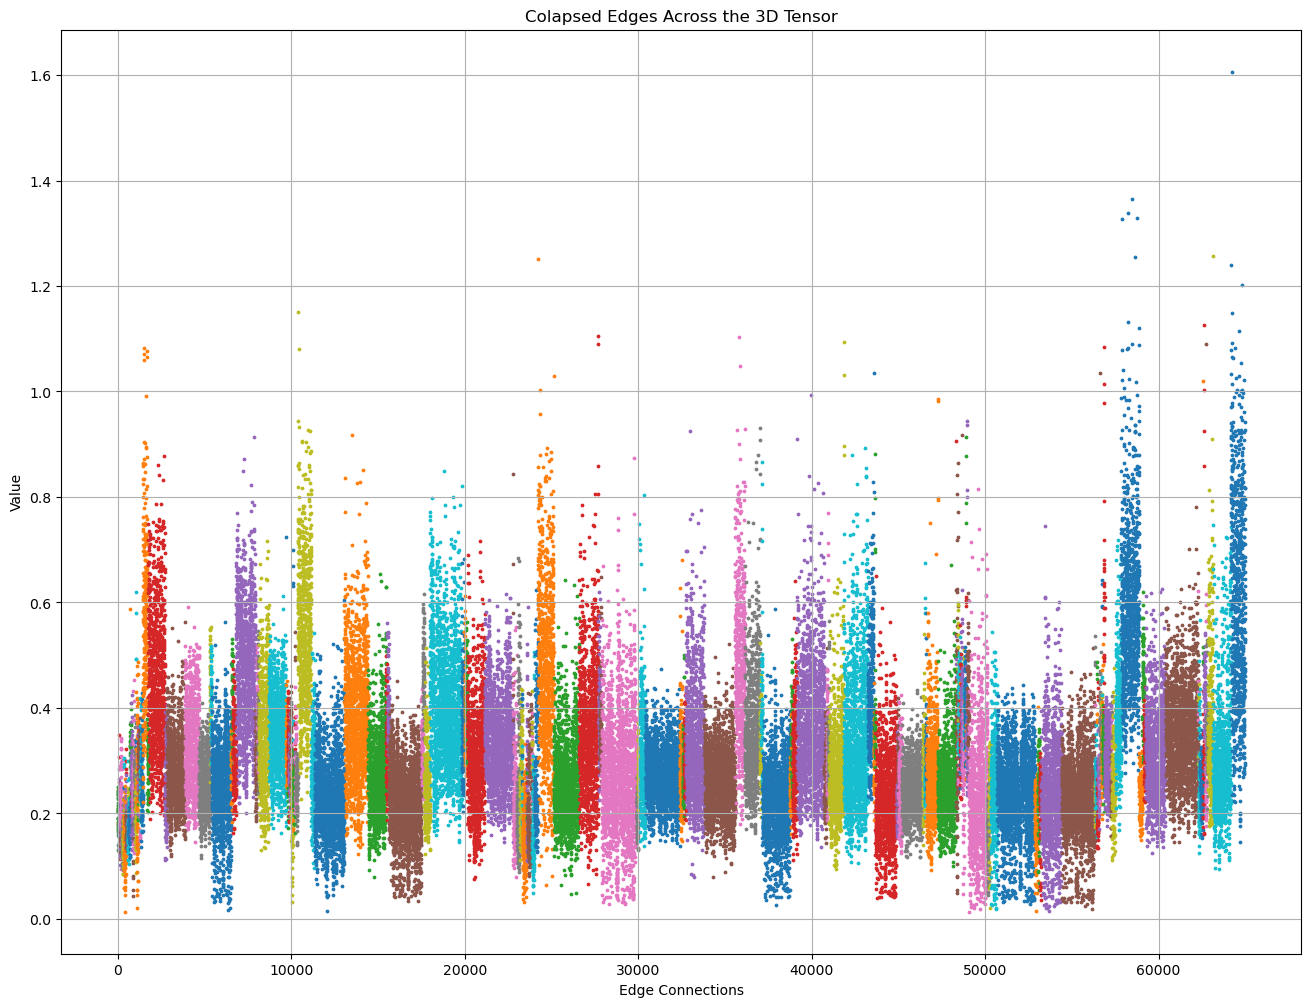

In [131]:
#Lets find the global average signal in the data. 

#We are going to average along all columns in the 3D tensor, then visualize.
average_edges = np.mean(tensor_data, axis=(1,2))
print(average_edges.shape)
average_edges = average_edges.reshape((64980, 1))
print(average_edges.shape)

# Get the dimensions of the  matrix
#rows, columns = average_edges.shape

#Incorporate Label Info
#label data
labels_data = scipy.io.loadmat('361_Longform_Sorted_Labels.mat')
labels = labels_data['sortedLabels']




# Create indices based on unique labels
unique_labels = np.unique(labels)
label_indices = {tuple(label): np.where(np.all(labels == label, axis=1))[0] for label in unique_labels}

print(len(labels))
print(len(unique_labels))

#print(label_indices)



# Scatter plot of generalized data.
plt.figure(figsize=(16, 12))
for label, indices in label_indices.items():
    plt.scatter(indices, average_edges[indices, 0], s=3, label=f'Label {label}')

plt.title('Colapsed Edges Across the 3D Tensor')
plt.xlabel('Edge Connections')
plt.ylabel('Value')
#plt.legend()
plt.grid(True)
plt.show()




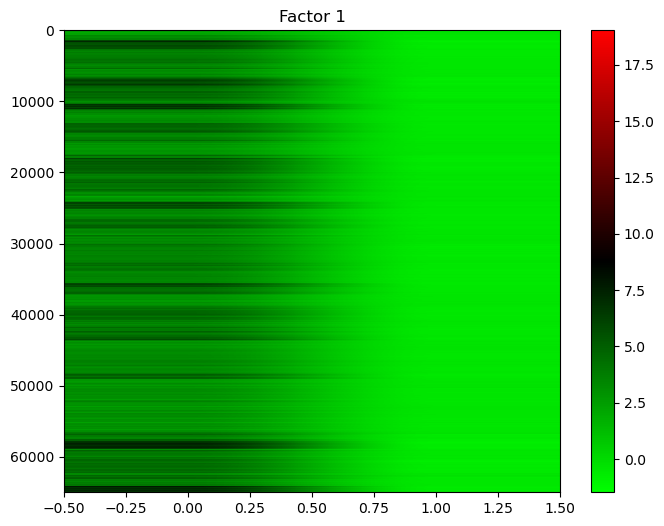

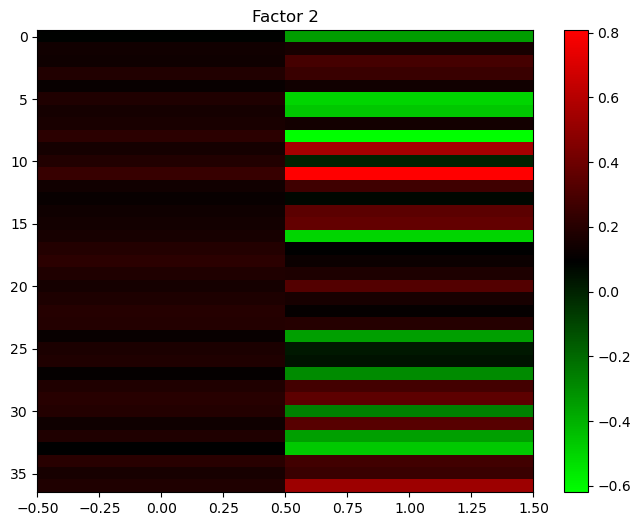

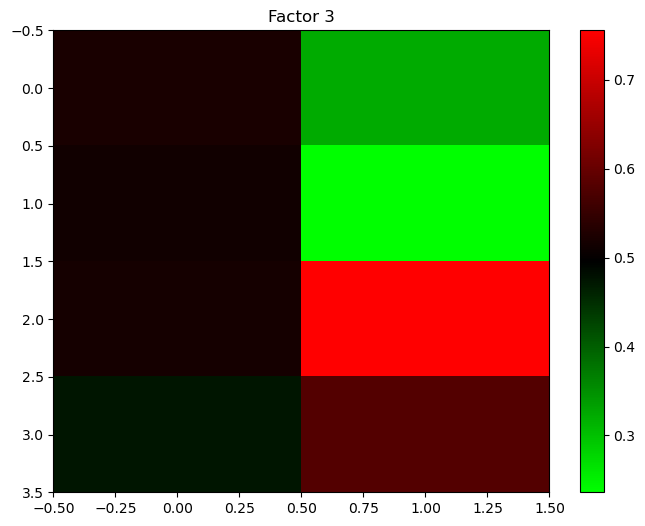

In [55]:
#lets visualize components

#make my colormap
cmap_colors = [(0, 1, 0), (0, 0, 0), (1, 0, 0)]  # Green, Black, Red

# Create a colormap with a gradient using LinearSegmentedColormap
custom_cmap = LinearSegmentedColormap.from_list("custom_cmap", cmap_colors, N=256)

# Visualize each factor matrix separately
for i in range(3):
    plt.figure(figsize=(8, 6))
    plt.imshow(factors[1][i], cmap=custom_cmap)
    plt.title(f'Factor {i + 1}')
    plt.axis('tight')
    plt.colorbar()
    plt.show()

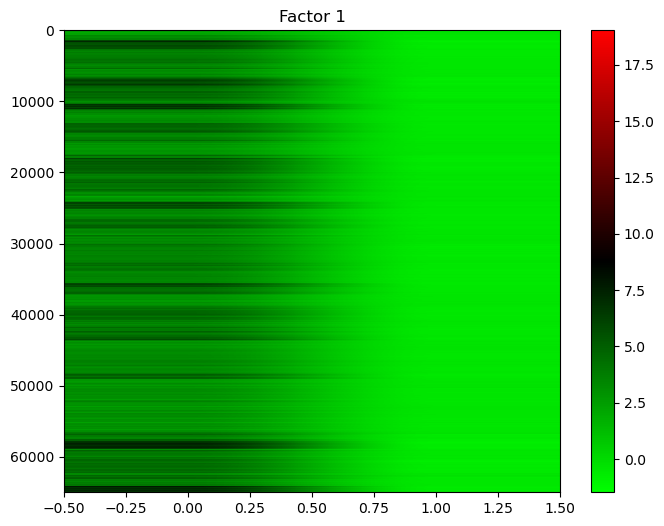

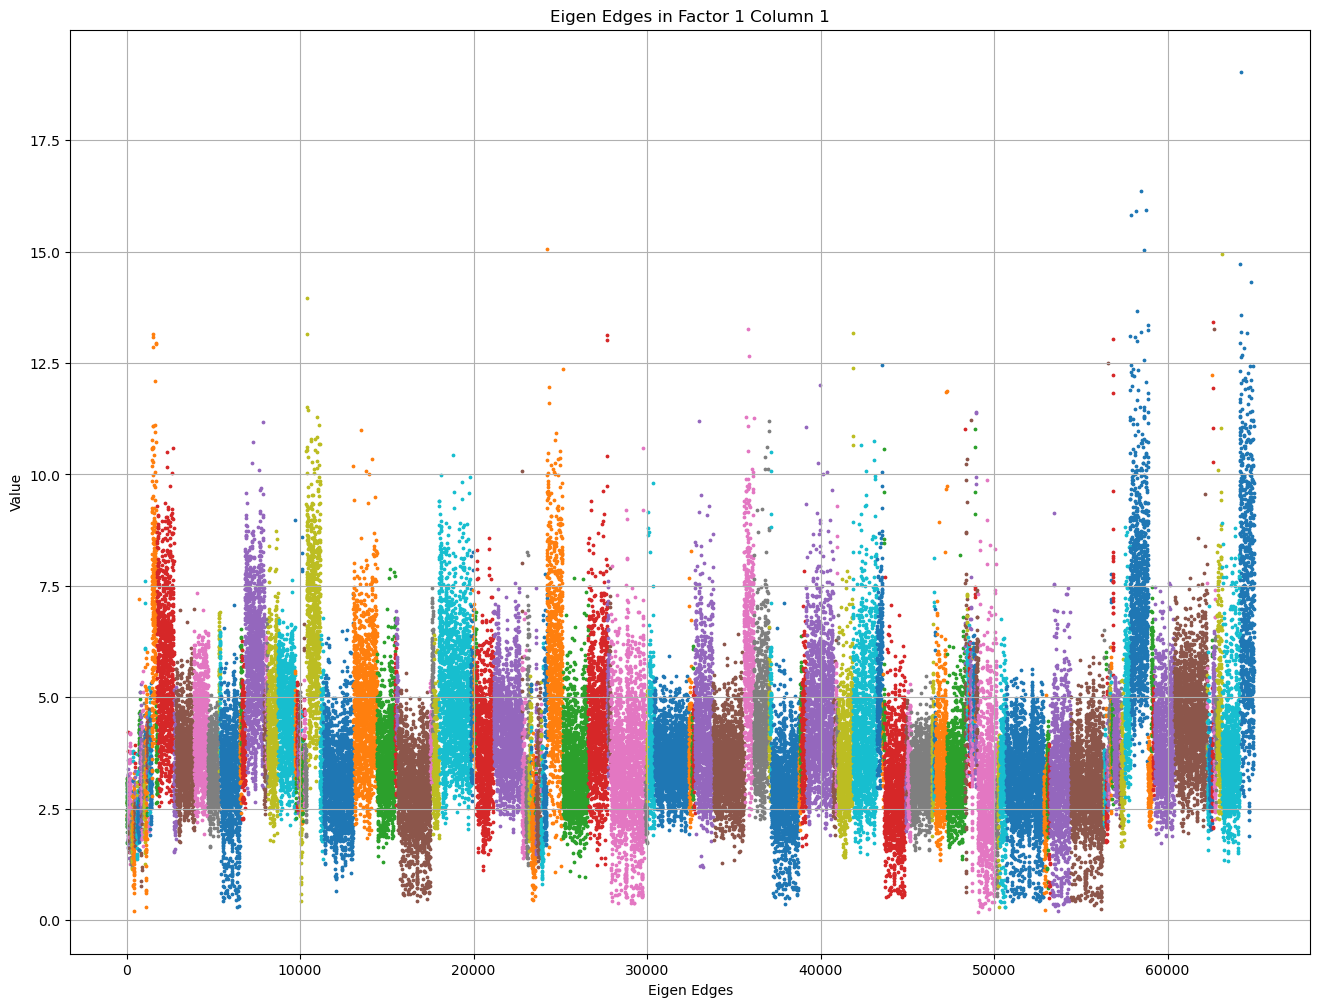

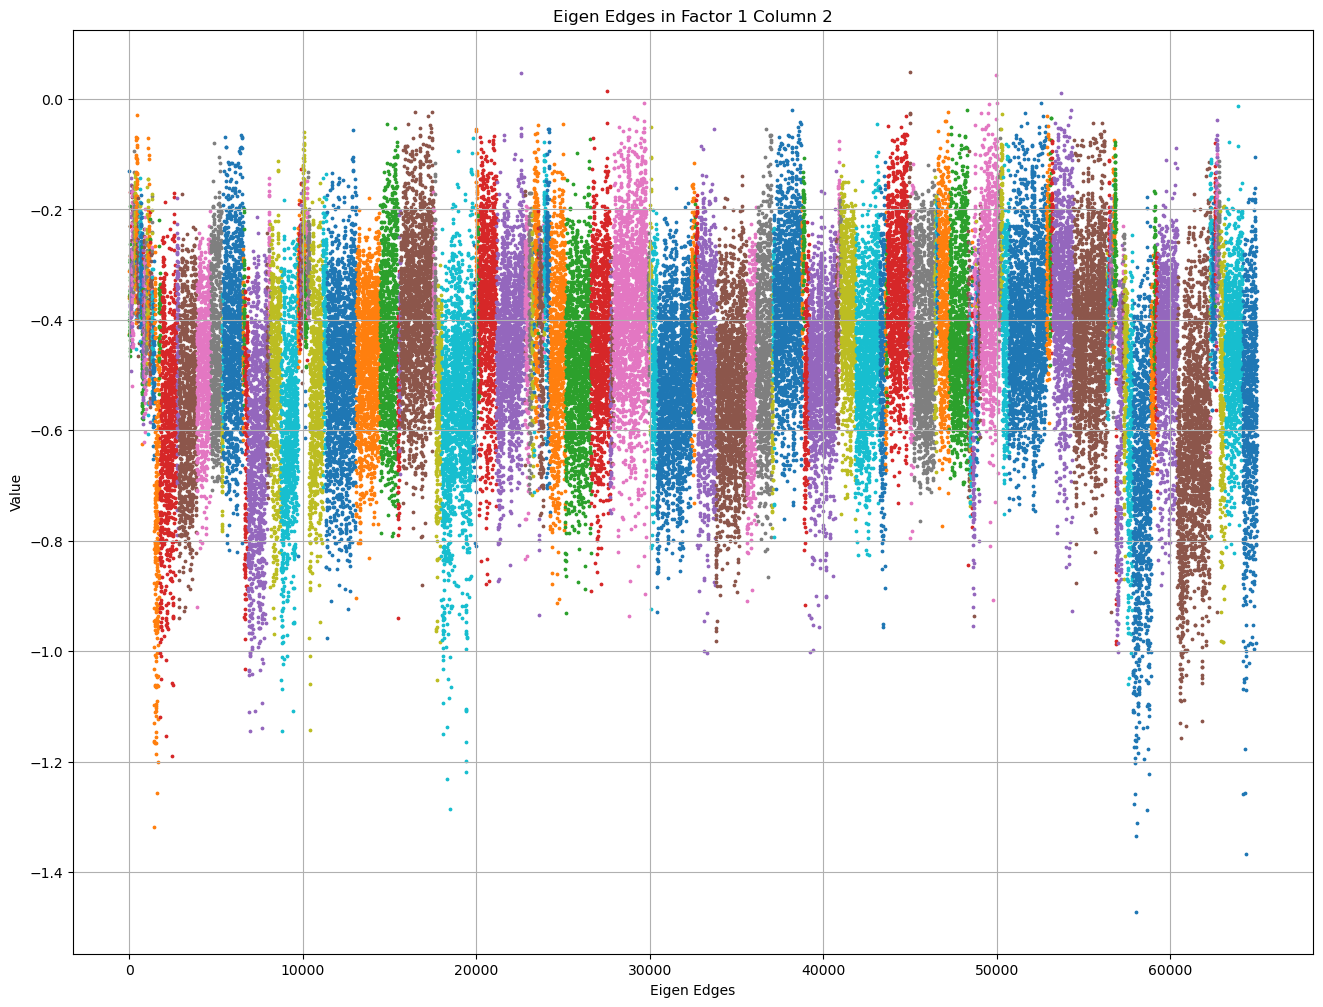

In [93]:

# Extract the first factor matrix
factor_one = factors[1][0]

# Get the dimensions of the factor matrix
rows, columns = factor_one.shape


# Visualize each column of the first factor matrix as a separate dot plot
for col in range(columns):
    plt.figure(figsize=(16, 12))
    for label, indices in label_indices.items():
        plt.scatter(indices, factor_one[indices, col], s=3, label=f'Label {label}')

    plt.title(f'Eigen Edges in Factor 1 Column {col + 1}')
    plt.xlabel('Eigen Edges')
    plt.ylabel('Value')
    #plt.legend()
    plt.grid(True)
    plt.show()


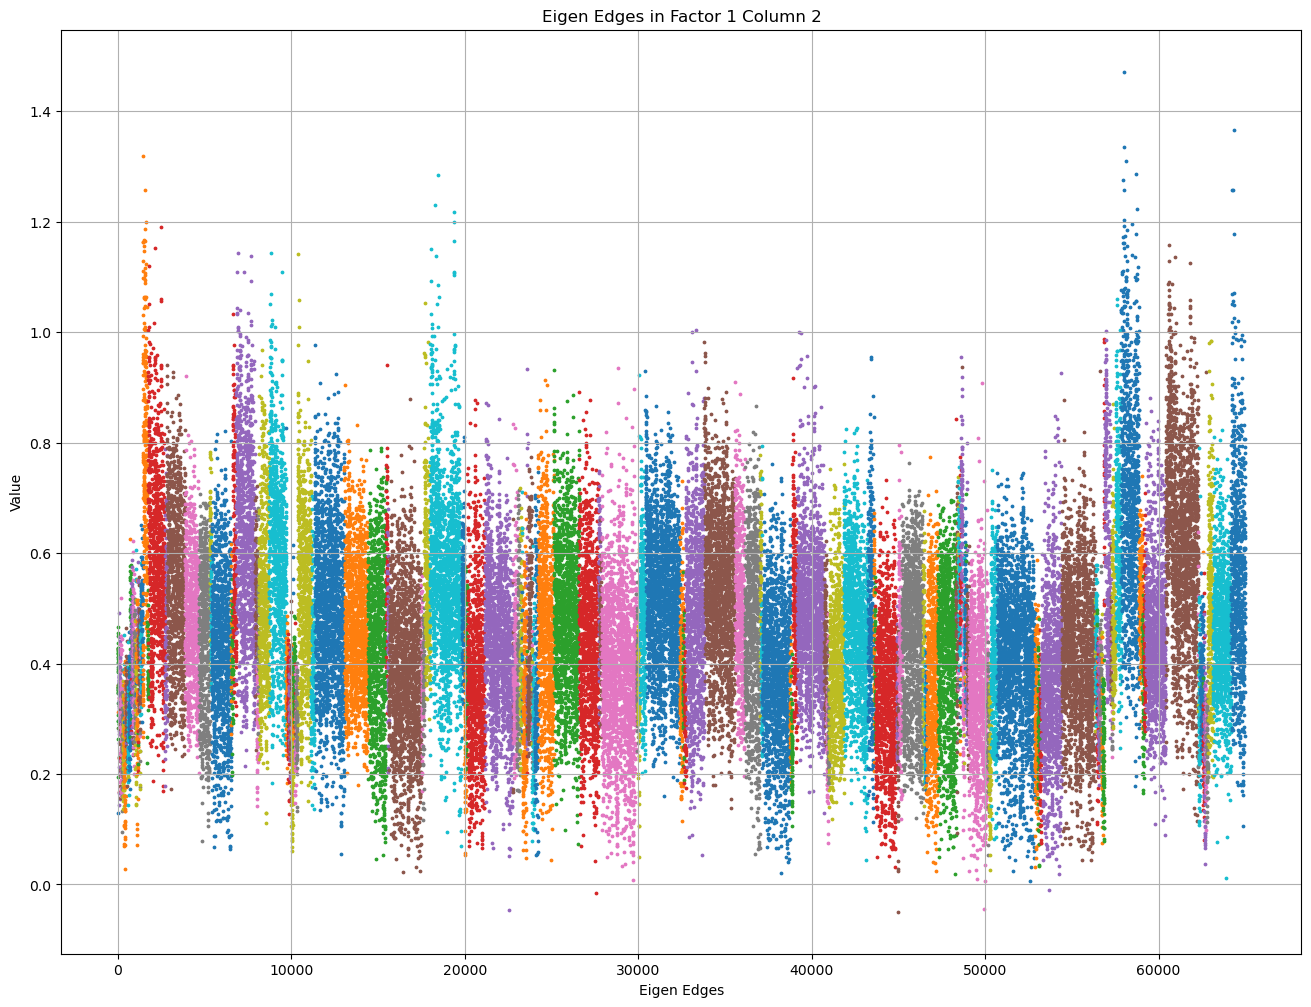

In [94]:
#Lets flip over factor 1 pattern 2 for visuals.

plt.figure(figsize=(16, 12))
for label, indices in label_indices.items():
    plt.scatter(indices, (factor_one[indices, 1] * -1), s=3, label=f'Label {label}')

plt.title('Eigen Edges in Factor 1 Column 2')
plt.xlabel('Eigen Edges')
plt.ylabel('Value')
#plt.legend()
plt.grid(True)
plt.show()


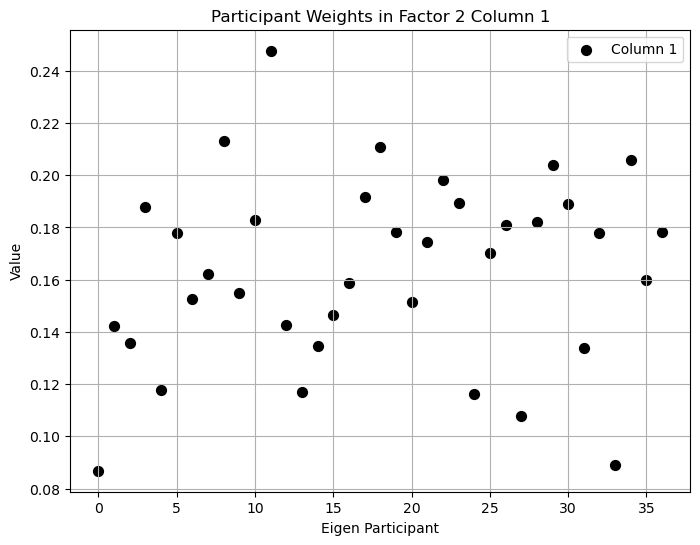

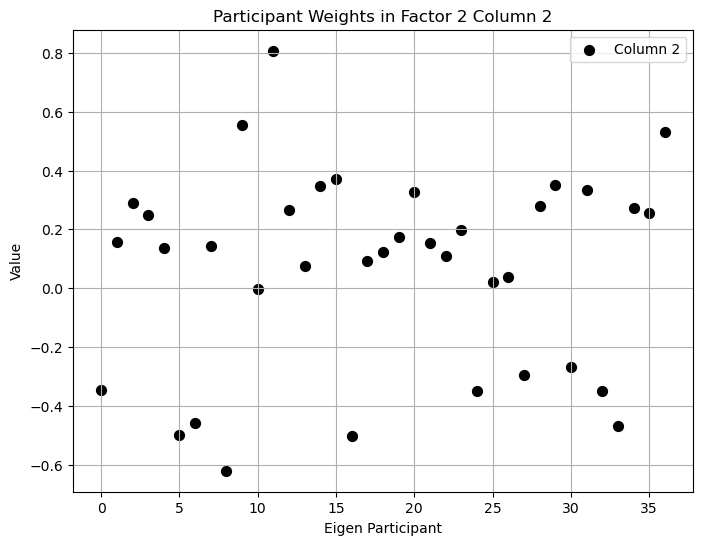

In [95]:
#Extract the second factor matrix
factor_two = factors[1][1]

# Get the dimensions of the factor matrix
rows, columns = factor_two.shape

# Visualize each column of the second factor matrix as a separate dot plot
for col in range(columns):
    plt.figure(figsize=(8, 6))
    plt.scatter(range(rows), factor_two[:, col], color='Black', s=50, label=f'Column {col + 1}')
    plt.title(f'Participant Weights in Factor 2 Column {col + 1}')
    plt.xlabel('Eigen Participant')
    plt.ylabel('Value')
    plt.legend()
    plt.grid(True)
    plt.show()

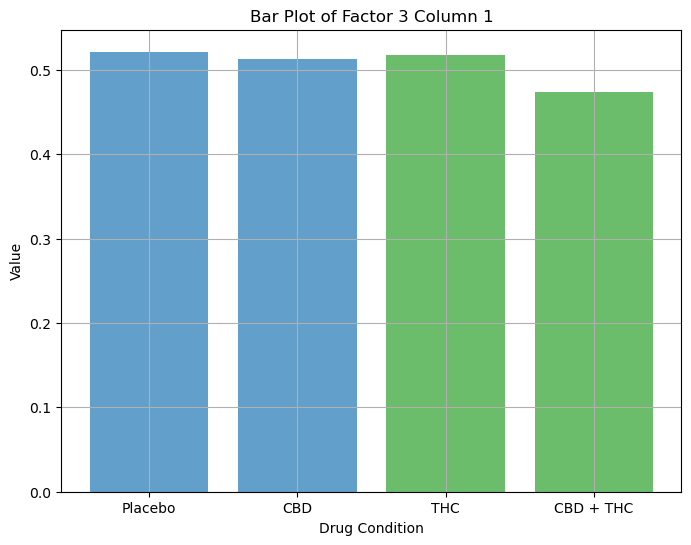

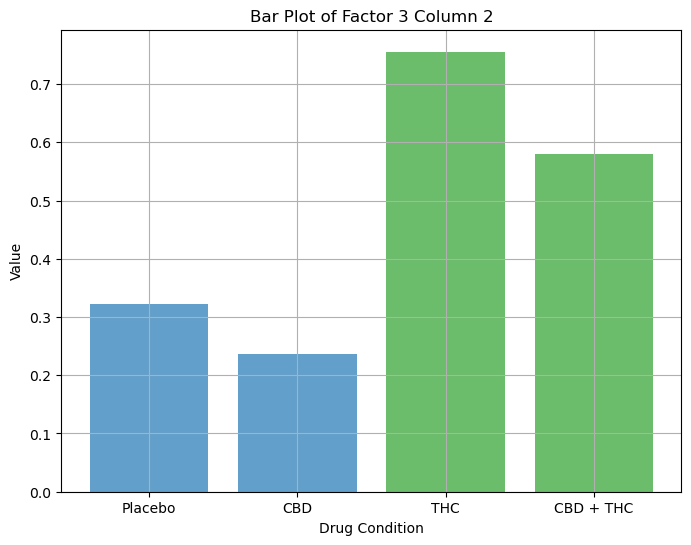

In [98]:

# Extract the third factor matrix
factor_three = factors[1][2]

# Get the dimensions of the factor matrix
rows, columns = factor_three.shape

#barplot labels
bar_labels = ['Placebo', 'CBD', 'THC', 'CBD + THC']
bar_colors = ['tab:blue', 'tab:blue', 'tab:green', 'tab:green']


# Visualize each column of the third factor matrix as a separate bar plot
for col in range(columns):
    plt.figure(figsize=(8, 6))
    plt.bar(bar_labels, factor_three[:, col], alpha=0.7, color = bar_colors)
    plt.title(f'Bar Plot of Factor 3 Column {col + 1}')
    plt.ylabel('Value')
    plt.xlabel('Drug Condition')
    plt.grid(True)
    plt.show()

In [ ]:
from scikit_posthocs import posthoc_dunn


#label data
labels_data = scipy.io.loadmat('361_Longform_Sorted_Labels.mat')
labels = labels_data['sortedLabels']


# Extract the first factor matrix
factor_one = factors[1][0]


# Create indices based on unique labels
unique_labels = np.unique(labels)
label_indices = {tuple(label): np.where(np.all(labels == label, axis=1))[0] for label in unique_labels}

# List to store significant column indices
significant_columns = []

# Perform Kruskal-Wallis test for each column
for col_idx in range(factor_one.shape[1]):
    # Extract data for the current column
    column_data = [factor_one[label_idx, col_idx] for label_idx in label_indices.values()]

    # Perform Kruskal-Wallis test
    stat, p_value = kruskal(*column_data)

    # Apply FWE correction using Bonferroni procedure
    reject_kw, corrected_p_value_kw, _, _ = sm.stats.multipletests([p_value], alpha=0.05, method='bonferroni')

    #check is corrected p-value is less than .05
    if reject_kw[0]:
        significant_columns.append((col_idx, corrected_p_value_kw[0]))
        print(f"Column {col_idx}: corrected p-value = {corrected_p_value_kw[0]} (Significant)")

        # Perform Dunn's test for pairwise comparisons -- a post hoc analysis
        posthoc_result = posthoc_dunn(column_data)

        # Print pairwise significant differences
        for i, group1 in enumerate(label_indices.keys()):
            for j, group2 in enumerate(label_indices.keys()):
                if i < j:
                    p_val = posthoc_result.iloc[i, j]
                    if p_val < 0.0000001:
                        print(f"{group1} vs {group2}: p-value = {p_val}")

        # Visualize box plot with significance annotations
        plt.boxplot(column_data, labels=[str(label) for label in label_indices.keys()])
        plt.title(f'Factor 1, Column {col_idx} is significant with p = {p_value}')
        plt.xlabel('Row Labels')
        plt.ylabel('Values')

        # Add significance annotations
        for i, group1 in enumerate(label_indices.keys()):
            for j, group2 in enumerate(label_indices.keys()):
                if i < j:
                    p_val = posthoc_result.iloc[i, j]
                    if p_val < 0.0000001:
                        plt.annotate('*', xy=(i + 1, max(column_data[i])), ha='center', va='bottom')

        plt.show()
                        